In [1]:
from Basic_Model import *
from Newton import *

In [2]:
def Simulation_Multitarget(w1,w2,w3,w4,r1,r2,targets,rewards_init,rewards_added,choice,NUM_TARGETS = 2):

    Categ = ["Left Target","Right Target"]
    Num_iter = 500
    dt = 0.001

    obj1,obj2 = targets[0] #Defini les targets

    xstart = np.array([0.4,0,0,2.15,0,0,obj1,0,obj2,0])
    x0 = np.array([0.4,0,0,2.15,0,0,obj1,0,obj2,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[8]])))
    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    Qnonlin = Q
    
    
    #Define Dynamic Matrices  
    Az = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    Bz = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Qnonlin

    s = rewards_init
    #Az = (Az-np.identity(NbreVar))/dt
    #Bz = Bz/dt
    array_L = np.zeros((Num_iter-1,2,NbreVar))   
    array_S = np.zeros((Num_iter,NbreVar,NbreVar)) 
    array_S[-1] = Qnonlin
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+Bz.T@S@Bz)@Bz.T@S@Az
        array_L[Num_iter-2-k] = L
        S = Az.T@S@(Az-Bz@L)
        array_S[Num_iter-2-k] = S
        
    #Az = Az*dt+np.identity(NbreVar)
    #Bz = Bz*dt
    #print(array_L[0])
    #Feedback
    H,L,x0,A,B = np.identity(8),array_L,xnonlin0,Az,Bz
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2)) 
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    Perturbation = 0
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat
    for k in range(Num_iter-1):
        if 33*np.sin(reelx[0]+reelx[1]) + 30*np.sin(reelx[0]) > 38 and Perturbation == 0:
            index_perturbed = k
            Perturbation = 1
        if Perturbation == 1 and k >= index_perturbed + 100:
            print(k)
            Perturbation = 2
            s += rewards_added
        #print(reelx[2],array_reelx[k-1][2])
        #x[0],x[1],x[3],x[4],x[2],x[5] = reelx[0],reelx[2],reelx[1],reelx[4],(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt
        min_index = 0
        min_value = np.infty
        for targ in range(NUM_TARGETS):
            tempx = np.copy(x)
            tempx[6:8] = targets[targ]
            if choice :
                if tempx.T@Qnonlin@tempx+s[targ] < min_value:
                    min_value,min_index = tempx.T@Qnonlin@tempx+s[targ],targ
            else :
                if tempx.T@array_S[k]@tempx+s[targ] < min_value:
                    min_value,min_index = tempx.T@array_S[k]@tempx+s[targ],targ
        if k%50 == 0 : print(k,"ms",Categ[min_index],"\n")
        xhat[6:8] = targets[min_index]
        x[6:8] = targets[min_index]
        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        v = -L[k].reshape(np.flip(B.shape))@xhat    
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))
            
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
    
        u = 1/K*M@v-1/K*M@Minvdot@M@np.array([x[2],x[5]])+M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])

        new_reelx[4:6] += dt*K*(u-reelx[4:6])
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    plt.figure(figsize=(6,10))
    targets = array_x[-1,6:8]
    plt.scatter(np.cos(targets[0]+targets[1])*33+np.cos(targets[0])*30,np.sin(targets[0]+targets[1])*33+np.sin(targets[0])*30,color = "green")
    plt.plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "blue")
    if array_x[1,6] != array_x[-1,6]:
        targets = array_x[1,6:8]
        plt.scatter(np.cos(targets[0]+targets[1])*33+np.cos(targets[0])*30,np.sin(targets[0]+targets[1])*33+np.sin(targets[0])*30,color = "red")

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
        
    plt.xlabel("x [cm]")
    plt.ylabel("y [cm]")
    plt.grid()
    plt.xlim((-10,10))
    plt.axis("equal")
    plt.plot(np.linspace(-10,10,1000),np.ones(1000)*(np.sin(reelx[0,index_perturbed]+reelx[1,index_perturbed])*33+np.sin(reelx[0,index_perturbed])*30),marker = "_",color = "black")
    plt.scatter(np.cos(reelx[0,index_perturbed+100]+reelx[1,index_perturbed+100])*33+np.cos(reelx[0,index_perturbed+100])*30,np.sin(reelx[0,index_perturbed+100]+reelx[1,index_perturbed+100])*33+np.sin(reelx[0,index_perturbed+100])*30,marker = "_",color = "black")
    plt.savefig("Multitarg.pdf")
    plt.show()
    #plt.legend()


#for perturbation in [np.array([300,150]),np.array([-300,0]),np.array([500,250]),np.array([-600,0])]:

0 ms Right Target 

50 ms Right Target 

100 ms Right Target 

150 ms Right Target 

200 ms Right Target 

250 ms Right Target 

300 ms Right Target 

312
350 ms Left Target 

400 ms Left Target 

450 ms Left Target 



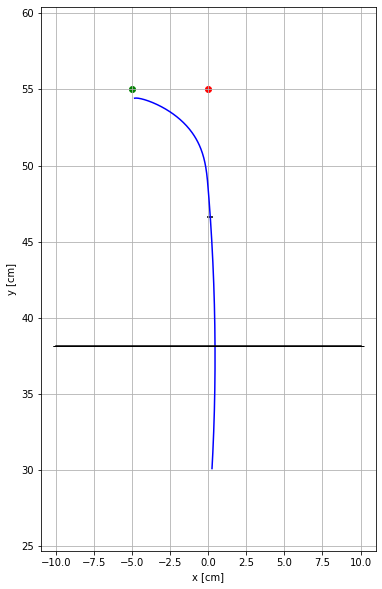

In [3]:
XAXIS = np.array([-5,0])
COSTS_INIT = np.zeros(2)
my_costs = np.array([0,6000])


targets = np.array([newton(f,df,1e-8,1000,XAXIS[0],55),newton(f,df,1e-8,1000,XAXIS[1],55)])
#Simulation_Multitarget(100000,100000,1000,1000,0.00001,0.00001,targets,COSTS_INIT,my_costs,False,2)
Simulation_Multitarget(100000,100000,1000,1000,0.00001,0.00001,targets,COSTS_INIT,my_costs,True,2)